In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Player clustering

Hi! In this file we take a dataset of all players from the popular game FIFA 18. There we cannot see their names but we can see their ID, preferred positions, and ratings at different positions. We will try to determine which of the three main positions they are best at: defender, midfielder, or forward (attacker).

In short, it takes their ratings from 9 of the most common positions when managers decide the starting eleven: *defenders*: CB, RB (fullback), RWB (wingback); *midfielders*: CDM, CM, CAM; *forwards*: ST, RW (winger), CF. Then it calculates the distance to the ideal defender, midfielder, and forward. You will see more details below.

In k-means clustering the centroids (in our case, the ideal defender, midfielder, and forward) change with each iteration, but in our example we can assume that we already know what the perfect centroids are.

Here is a short dictionary of the positions in football:
1. GK: goalkeeper
2. Defenders
- CB: centre-back
- LCB: left centre-back
- RCB: right centre-back
- LB: left-back
- RB: right-back
- LWB: left wing-back
- RWB: right wing-back
3. Midfielders
- CM: central midfielder
- CAM: central attacking midfielder
- CDM: central defensive midfielder
- RDM: right defensive midfielder
- LDM: left defensive midfielder
- LCM: left central midfielder
- RCM: right central midfielder
- RAM: right attacking midfielder
- LAM: left attacking midfielder
- LM: left midfielder
- RM: right midfielder
4. Forwards
- ST: striker
- CF: second striker
- RW: right-winger
- LW: left-winger
- LS: left striker
- RS: right striker
- LF: left second striker
- RF: right second striker

*Note that this is a simple code and it does not consider their attributes (shooting, tackling, passing, etc.)*

In [3]:
def find_euclidean_distance(p_coor, q_coor):
    """ Finds the Euclidean distance between two points with coordinates p and q """
    
    return np.sqrt((sum(((p_coor[i]-q_coor[i])**2) for i in range(len(p_coor)))))

In [4]:
def move_column(df, column, position):
    """ Moves a column from a DataFrame to a given position """
    col = df.pop(column)
    df.insert(position, column, col)
    return df

In [5]:
"""Loading the dataset with the players """

players = pd.read_csv("PlayerPlayingPositionData.csv")

Our first task once the data is loaded is to remove some position ratings for two reasons: 1) they are not that common 2) we already have the same rating at almost the same position (e.g. FIFA does not care if a left-back is played as a right-back or a centre-back as a left centre-back). We have also removed goalkeepers (as we already know their best position). As you see we drop the attribute Preferred Positions (these are the positions they play in real life (we are not sure whether these are their best positions (in some cases they are not))). Then we arrange it as we want to.

In [7]:
""" fixing the dataset """

players_fixed = players[~players["Preferred Positions"].str.contains("GK")]
players_fixed.reset_index(drop = True, inplace = True)
players_fixed = players_fixed.drop(columns = ["Preferred Positions","LAM", "LB","LCB", "LCM", "LDM", "RM", "LF", "LM", "LW", "LS", "LWB", "RAM", "RCB", "RCM", "RDM", "RF", "RS"])
players_fixed = players_fixed.drop(players_fixed.columns[0], axis = 1)
players_fixed = move_column(players_fixed, "ID", 0)
players_fixed = move_column(players_fixed, "CB", 1)
players_fixed = move_column(players_fixed, "RB", 2)
players_fixed = move_column(players_fixed, "RWB", 3)
players_fixed = move_column(players_fixed, "CDM", 4)
players_fixed = move_column(players_fixed, "CM", 5)
players_fixed = move_column(players_fixed, "CAM", 6)

players_fixed = move_column(players_fixed, "RW", 7)
players_fixed = move_column(players_fixed, "ST", 8)


Let's see what we got:

In [9]:
players_fixed.sample()

,ID,CB,RB,RWB,CDM,CM,CAM,RW,ST,CF
15812,240203,45.0,46.0,47.0,46.0,48.0,49.0,48.0,45.0,48.0


In [10]:
""" Storing all player stats as a 2D numpy array """
all_players = np.vstack(players_fixed.to_numpy())

In the cell below, we design our *ideal* players – they are the best at all e.g. midfield positions and cannot play the other two.

In [12]:
defender = np.array([99, 99, 99, 0, 0, 0, 0, 0, 0])
midfielder = np.array([0, 0, 0, 99, 99, 99, 0, 0, 0])
forward = np.array([0, 0, 0, 0, 0, 0, 99, 99, 99])

In [13]:
positions = []
for i in range(all_players.shape[0]):
    """ Finding the best position for all of the players """
    def_dist = find_euclidean_distance(all_players[i, range(1, 10)], defender)
    mid_dist = find_euclidean_distance(all_players[i, range(1, 10)], midfielder)
    att_dist = find_euclidean_distance(all_players[i, range(1, 10)], forward)
    
    if min(def_dist, mid_dist, att_dist) == def_dist:
        positions.append("defender")
    elif min(def_dist, mid_dist, att_dist) == mid_dist:
        positions.append("midfielder")
    elif min(def_dist, mid_dist, att_dist) == att_dist:
        positions.append("forward")

In [14]:
players_fixed["Position"] = positions

In [15]:
players_fixed.sample()

,ID,CB,RB,RWB,CDM,CM,CAM,RW,ST,CF,Position
13198,238446,59.0,57.0,54.0,54.0,46.0,43.0,43.0,44.0,42.0,defender


Now we have added another column to the fixed DataFrame where we put the best position of a player based on the Euclidean distance to the main positions. Let's play with the data a little bit.

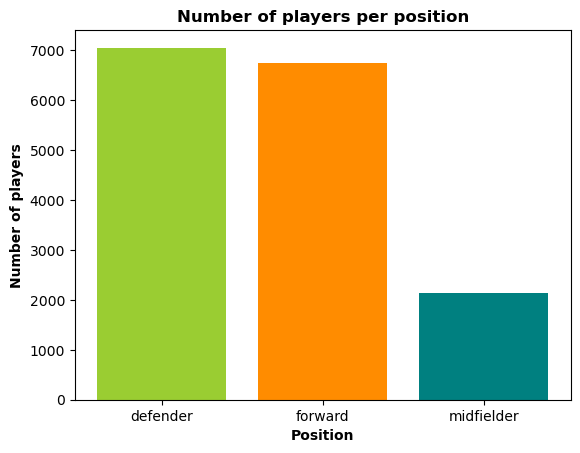

In [17]:
""" Plotting the number of players per position """


plt.bar(players_fixed["Position"].value_counts().index, players_fixed["Position"].value_counts(), color = ["yellowgreen", "darkorange", "teal"])
plt.xlabel("Position", fontweight = "bold")
plt.ylabel("Number of players",  fontweight = "bold")
plt.title("Number of players per position",  fontweight = "bold")
plt.show()

As we see, midfielder is the least common position. That is not due to the fact that there are no midfielders. The real reason for that is because most of them are *specialized* – they are either a CDM (central defensive midfielder) or a CAM (central attacking midfielder). That means, for example, a CAM can play better as a ST (striker) than as a CDM. Also, in real life, a CAM playing as a winger or striker is a way more common than him playing as a CDM. For the goals we set for ourselves, a CAM who can play any forward position well enough, but cannot play as a CDM, should be considered a forward. Look at Kevin De Bruyne for instance:

In [19]:
players_fixed[players_fixed["ID"] == 192985]

,ID,CB,RB,RWB,CDM,CM,CAM,RW,ST,CF,Position
9,192985,57.0,66.0,71.0,70.0,84.0,86.0,85.0,81.0,85.0,forward


It is clear that his main position is CAM, but he is not an *all-rounded* (football term) midfielder. So, we determine him as a forward as he is excellent at every attacking position. In other words, he is closer to the ideal forward than to the ideal midfielder. Also, look at İlkay Gündoğan, who is a great all-rounded midfielder:

In [21]:
players_fixed[players_fixed["ID"] == 186942]

,ID,CB,RB,RWB,CDM,CM,CAM,RW,ST,CF,Position
69,186942,69.0,73.0,75.0,77.0,83.0,84.0,81.0,76.0,81.0,midfielder
